# IHAR historical phenotypic wheat data analysis
origin and version of the input files: 
- https://urgi.versailles.inrae.fr/fairdom/data_files/54?version=4
- https://urgi.versailles.inrae.fr/fairdom/data_files/55?version=3

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)
asreml.options(workspace="20gb")
source("../custom_functions.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union




The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: Biobase



Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.




Loading required package: Matrix




Attaching package: ‘Matrix’




The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Online License checked out Fri May 24 17:56:52 2024


Loading ASReml-R version 4.2




In [2]:
data_total_winter <- preprocess("IHAR Phenotypic_Historical-winter wheat.xlsx", obs_col_types = c('numeric', rep('text', 5), rep('numeric', 22)))
write_csv(data_total_winter, "IHAR_winter_wheat.csv")
genotypes_w <- distinct(data_total_winter["accenumb"]) |> rename("genotype" = "accenumb")
cat("Winter Wheat:\n", nrow(data_total_winter), "observations\n", nrow(genotypes_w), "genotypes\n", nrow(distinct(data_total_winter["campaign"])), "campaigns\n\n")
summary(data_total_winter[c("beginning_of_heading", "end_of_heading", "plant_height", "thousand_kernel_weight")])

Winter Wheat:
 10673 observations
 5267 genotypes
 25 campaigns



 beginning_of_heading end_of_heading   plant_height   thousand_kernel_weight
 Min.   :125.0        Min.   :125.0   Min.   : 31.0   Min.   : 1.00         
 1st Qu.:147.0        1st Qu.:155.0   1st Qu.: 83.4   1st Qu.:36.40         
 Median :154.0        Median :163.0   Median : 99.7   Median :41.10         
 Mean   :153.8        Mean   :163.2   Mean   :100.6   Mean   :40.63         
 3rd Qu.:161.0        3rd Qu.:171.0   3rd Qu.:116.7   3rd Qu.:45.20         
 Max.   :182.0        Max.   :343.0   Max.   :613.5   Max.   :87.00         
 NA's   :8038         NA's   :391                                           

In [3]:
data_total_spring <- preprocess("IHAR Phenotypic_Historical-spring wheat.xlsx", obs_col_types = c('numeric', rep('text', 5), rep('numeric', 4), 'skip', rep('numeric', 8))) |> 
                        mutate(beginning_of_heading = heading_date_to_days(beginning_of_heading_date)) |>
                        mutate(end_of_heading = heading_date_to_days(end_of_heading_date))
write_csv(data_total_spring, "IHAR_spring_wheat.csv")
genotypes_s <- distinct(data_total_spring["accenumb"]) |> rename("genotype" = "accenumb")
cat("Spring Wheat:\n", nrow(data_total_spring), "observations\n", nrow(genotypes_s), "genotypes\n", nrow(distinct(data_total_spring["campaign"])), "campaigns\n\n")
summary(data_total_spring[c("beginning_of_heading", "end_of_heading", "plant_height", "thousand_kernel_weight")])

Spring Wheat:
 5376 observations
 2340 genotypes
 27 campaigns



 beginning_of_heading end_of_heading   plant_height    thousand_kernel_weight
 Min.   :129.0        Min.   :138.0   Min.   : 40.00   Min.   : 4.00         
 1st Qu.:158.0        1st Qu.:167.0   1st Qu.: 82.38   1st Qu.:34.50         
 Median :164.0        Median :172.0   Median : 97.00   Median :38.40         
 Mean   :165.1        Mean   :172.1   Mean   : 96.41   Mean   :38.63         
 3rd Qu.:171.0        3rd Qu.:177.0   3rd Qu.:110.00   3rd Qu.:42.50         
 Max.   :343.0        Max.   :221.0   Max.   :162.00   Max.   :70.00         
 NA's   :4720         NA's   :658                                            

Let's choose "end of heading" as heading time trait, as it has way less NAs than "beginning of heading"

## Subset data, remove missing values and singletons, make factors

In [4]:
cat("Winter:\n")
data_sub_WW_HT <- data_total_winter |> make_data_sub("end_of_heading", 50, 250)
data_sub_WW_PH <- data_total_winter |> make_data_sub("plant_height", 5, 250)
data_sub_WW_TKW <- data_total_winter |> make_data_sub("thousand_kernel_weight", 5, 100)

Winter:


8211 end_of_heading rows kept


8815 plant_height rows kept


8786 thousand_kernel_weight rows kept


In [5]:
cat("Spring:\n")
data_sub_SW_HT <- data_total_spring |> make_data_sub("end_of_heading", 50, 250)
data_sub_SW_PH <- data_total_spring |> make_data_sub("plant_height", 5, 250)
data_sub_SW_TKW <- data_total_spring |> make_data_sub("thousand_kernel_weight", 5, 100)

Spring:


3348 end_of_heading rows kept


4053 plant_height rows kept


4170 thousand_kernel_weight rows kept


## Visualise trait values 

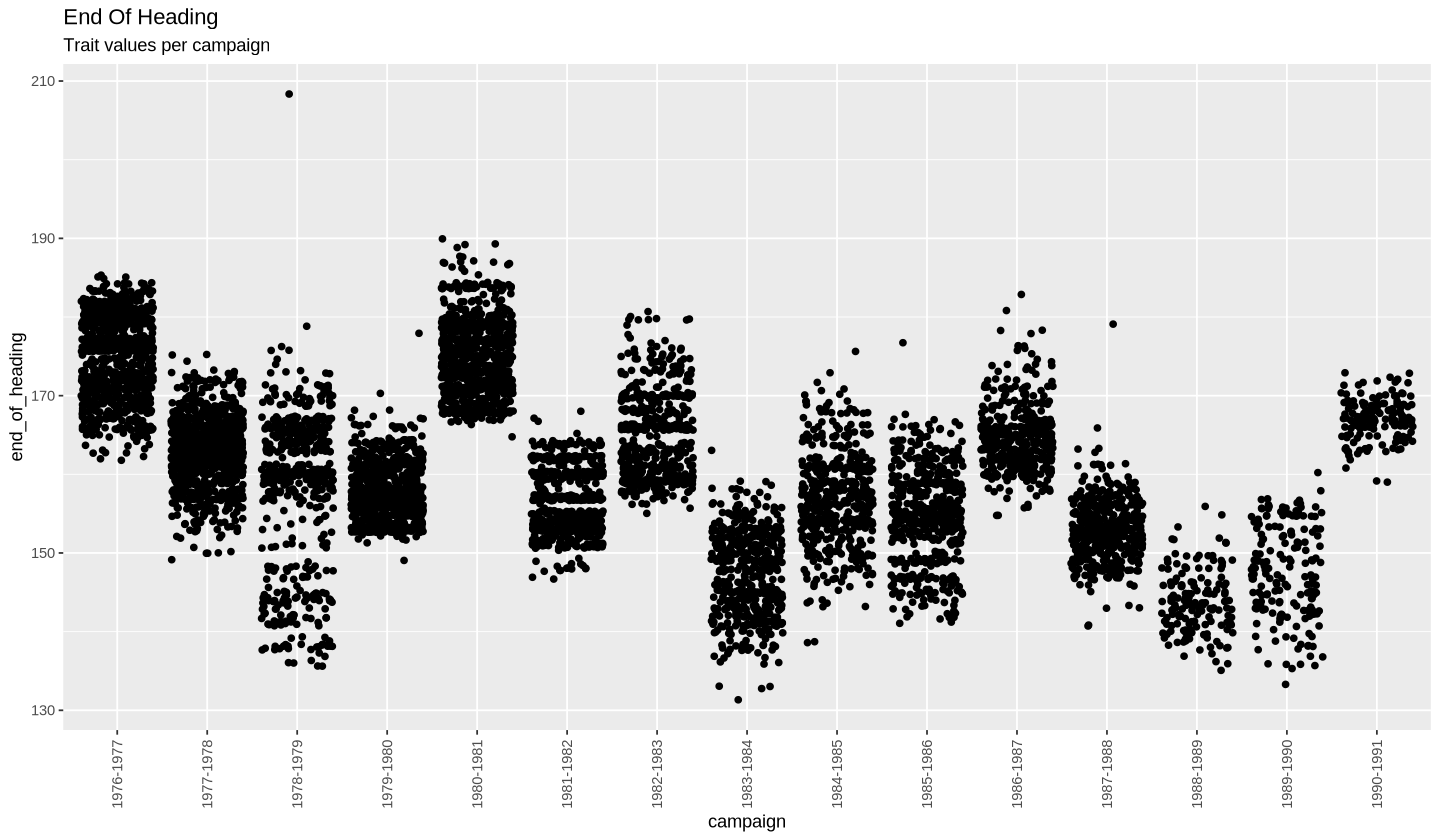

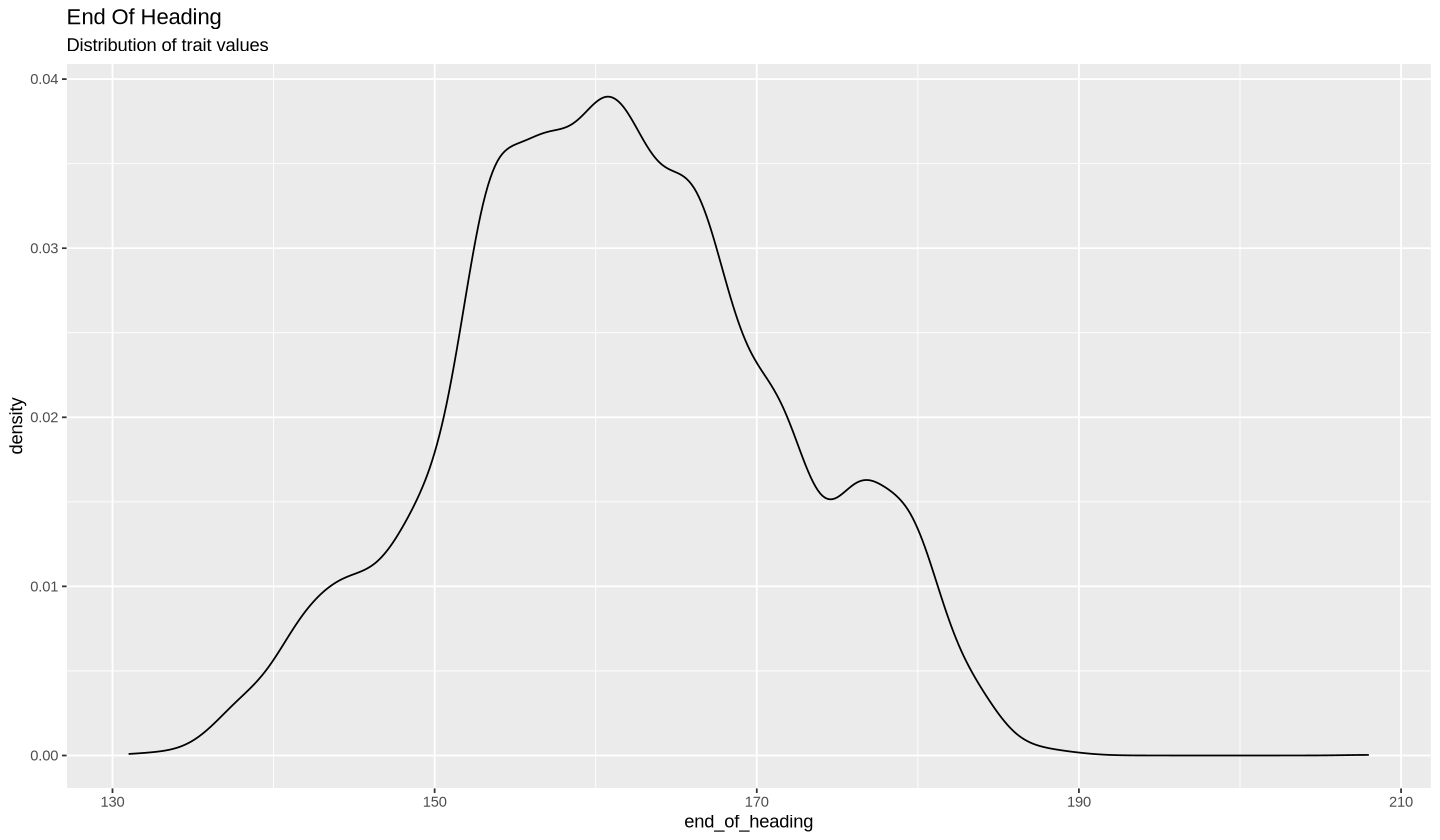

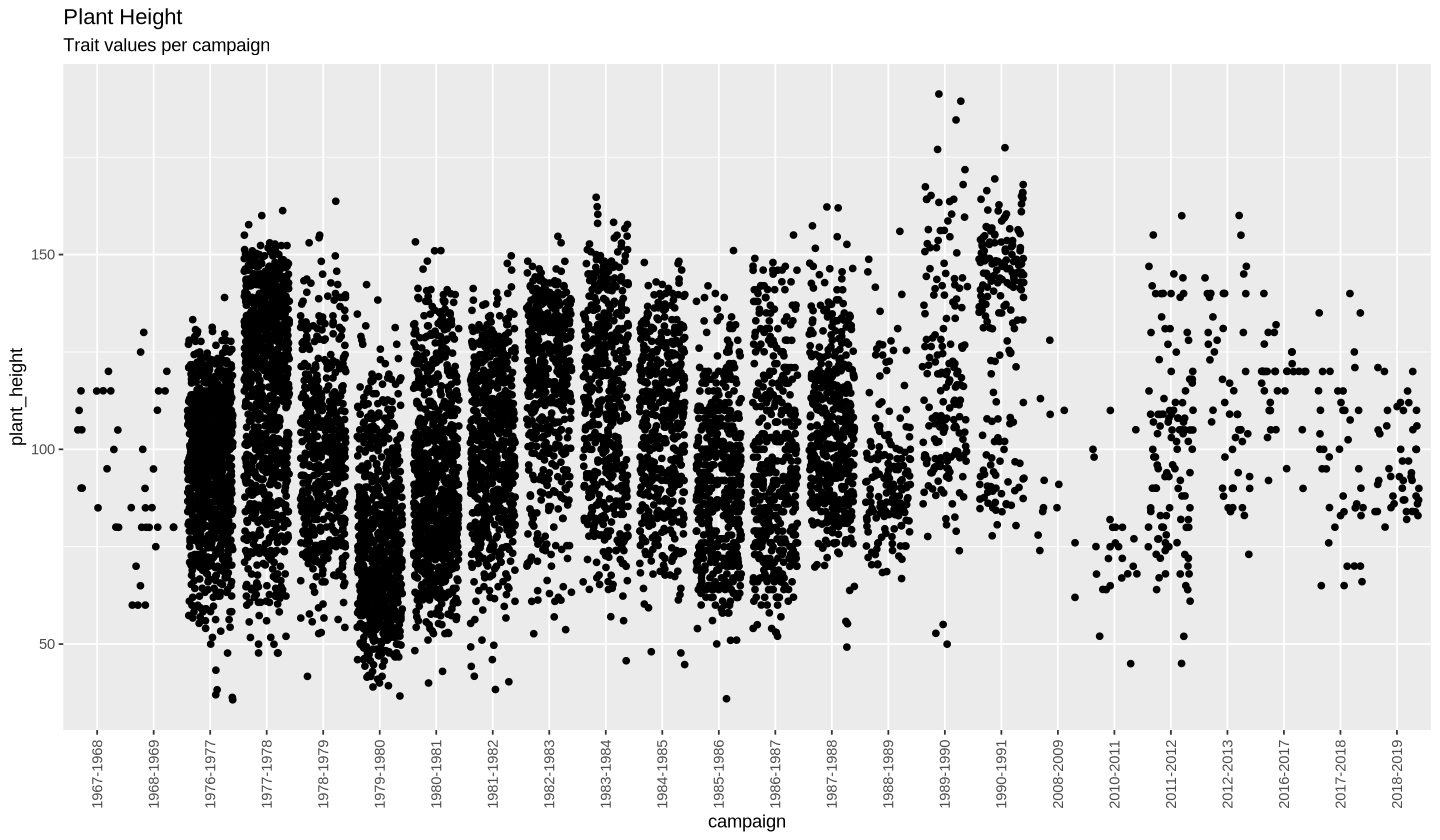

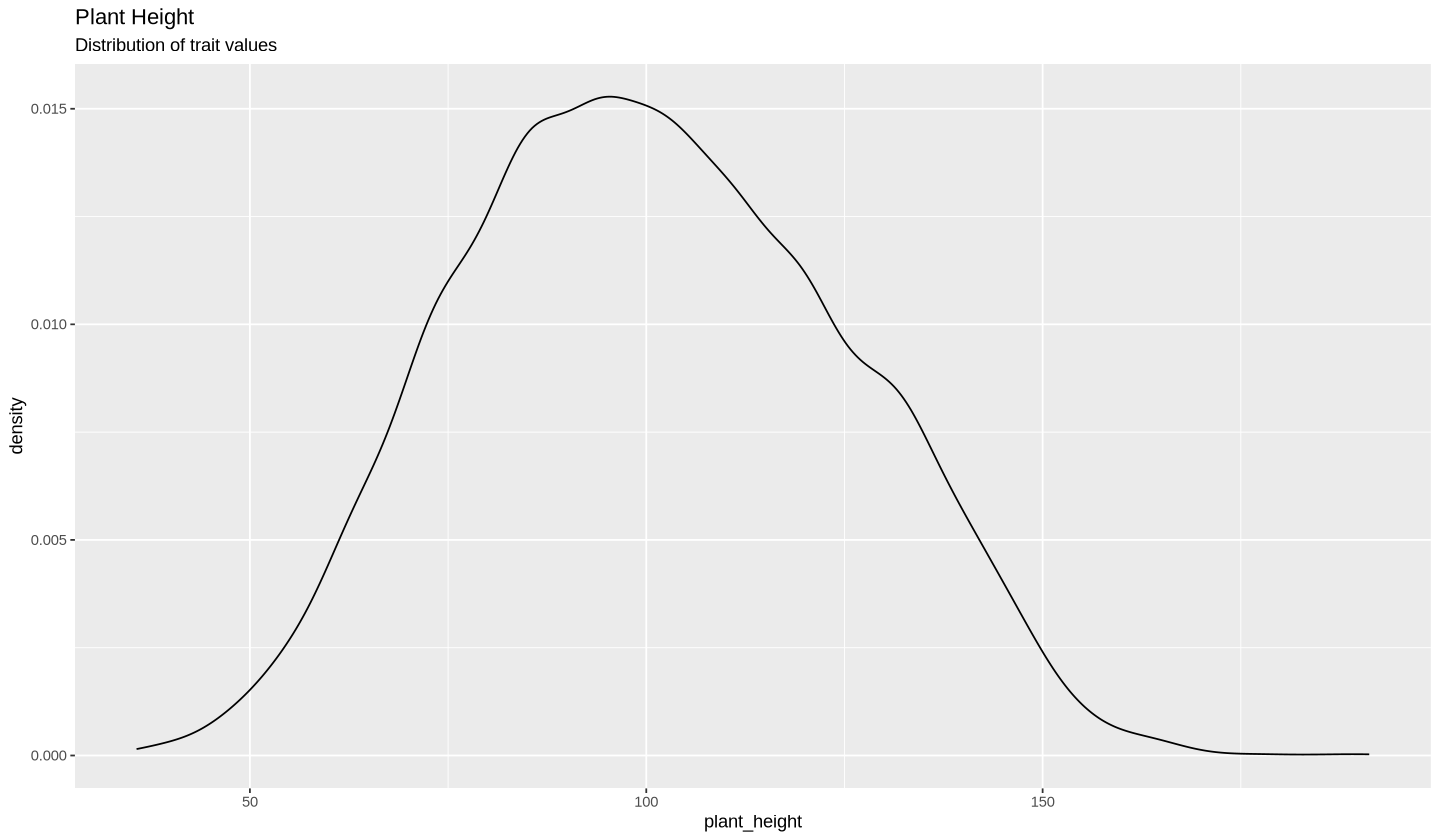

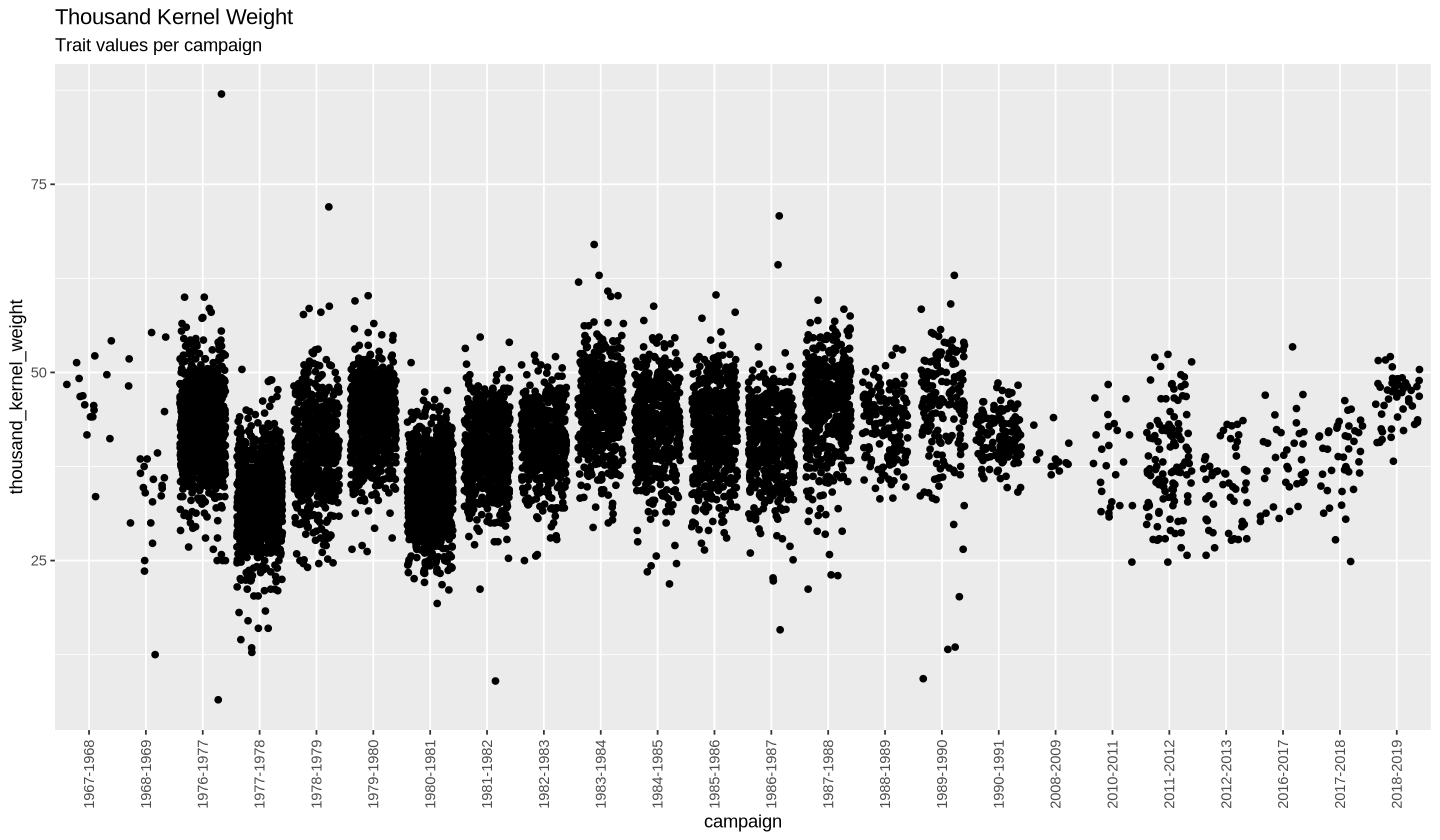

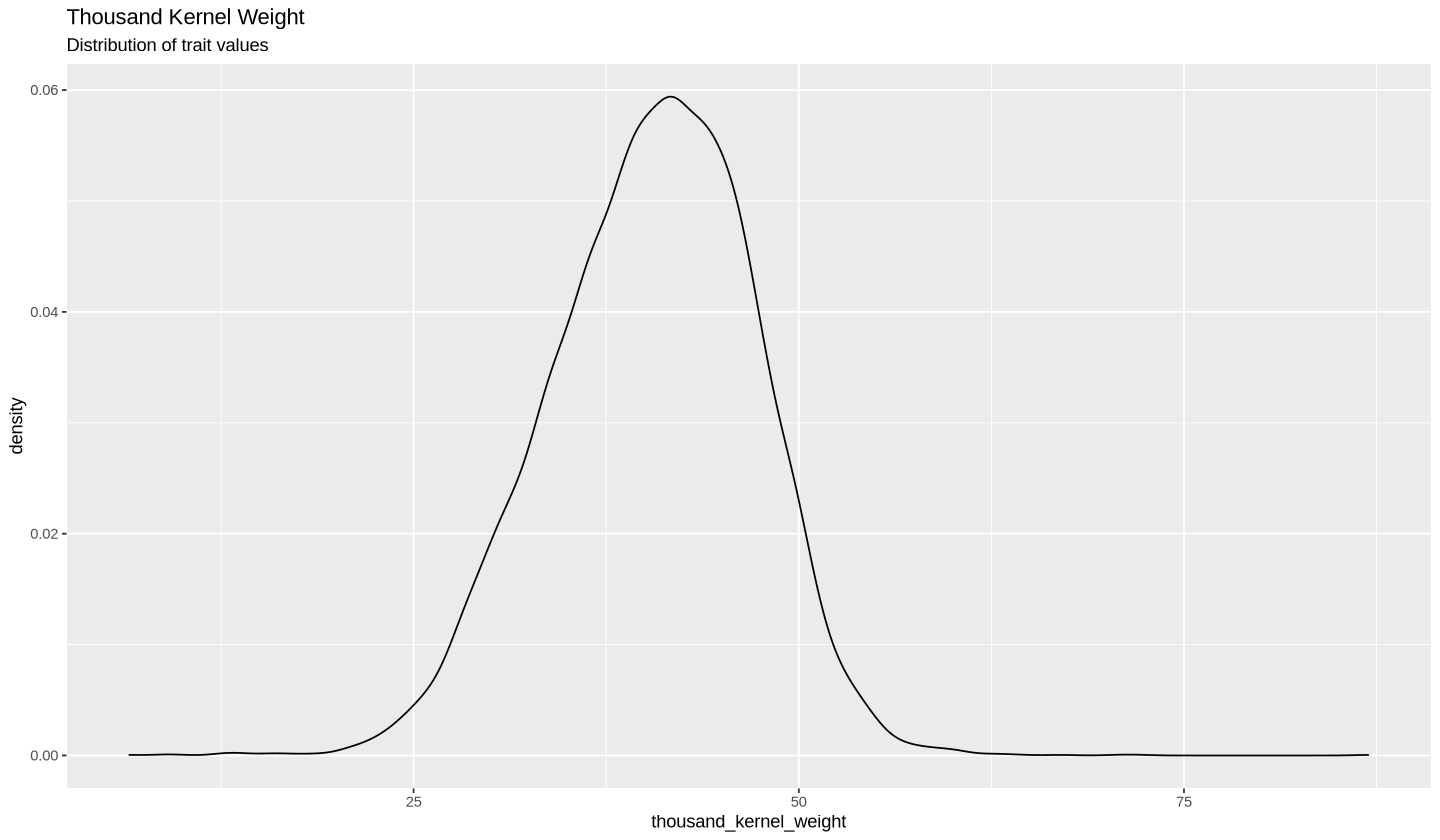

In [6]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_WW_HT |> visualise_trait(geom_density())
data_sub_WW_PH |> visualise_trait(geom_density())
data_sub_WW_TKW |> visualise_trait(geom_density())

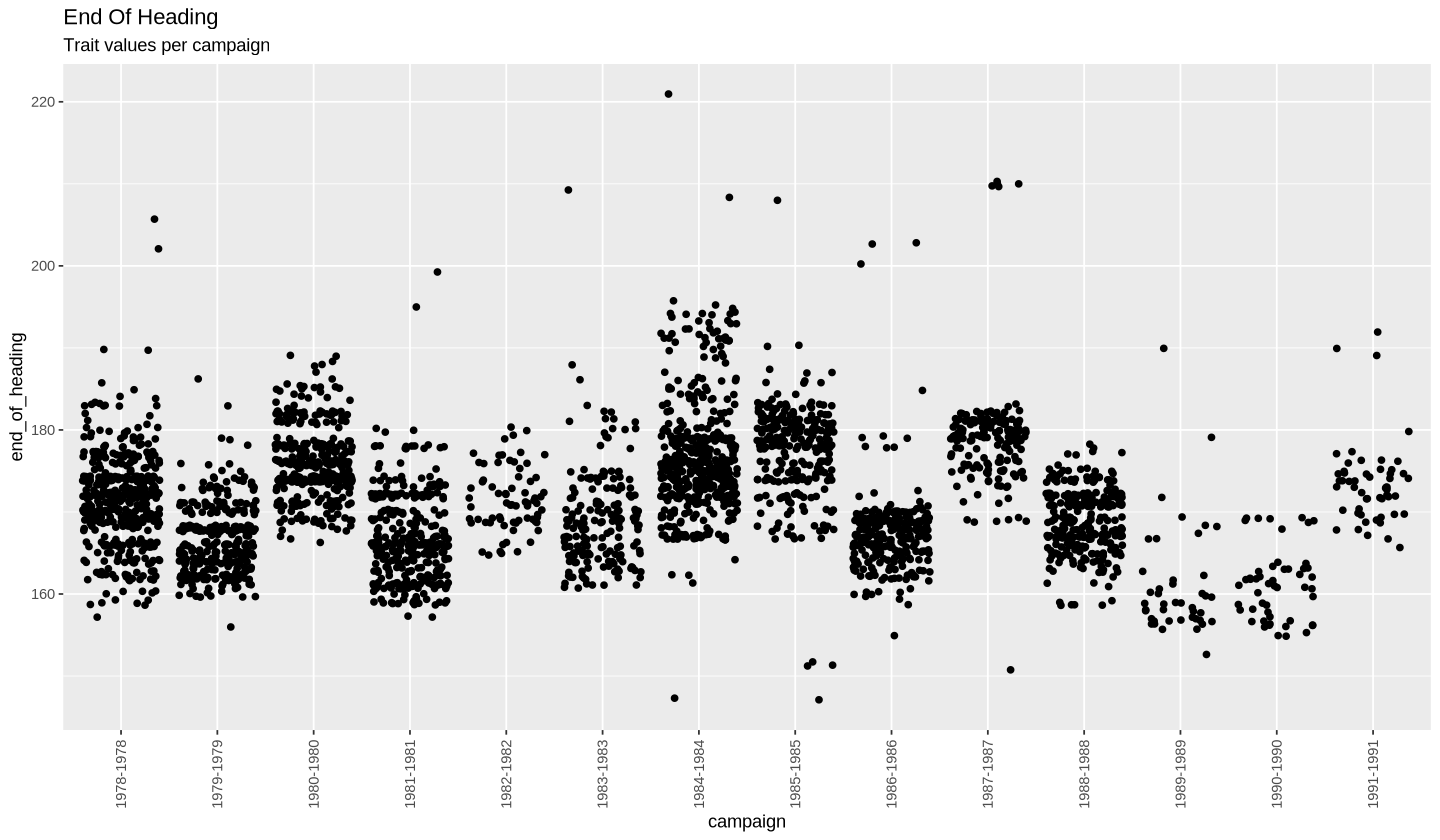

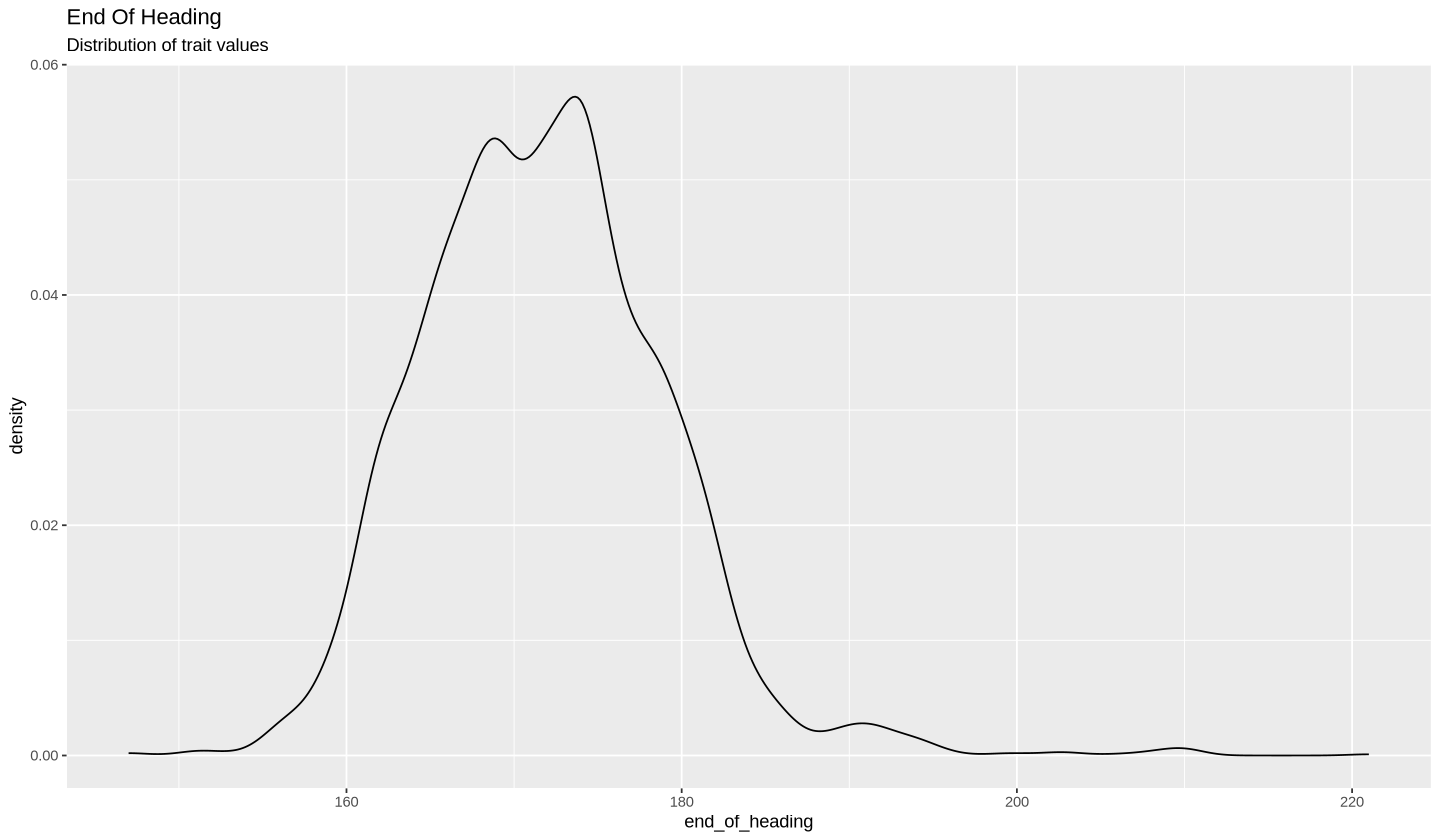

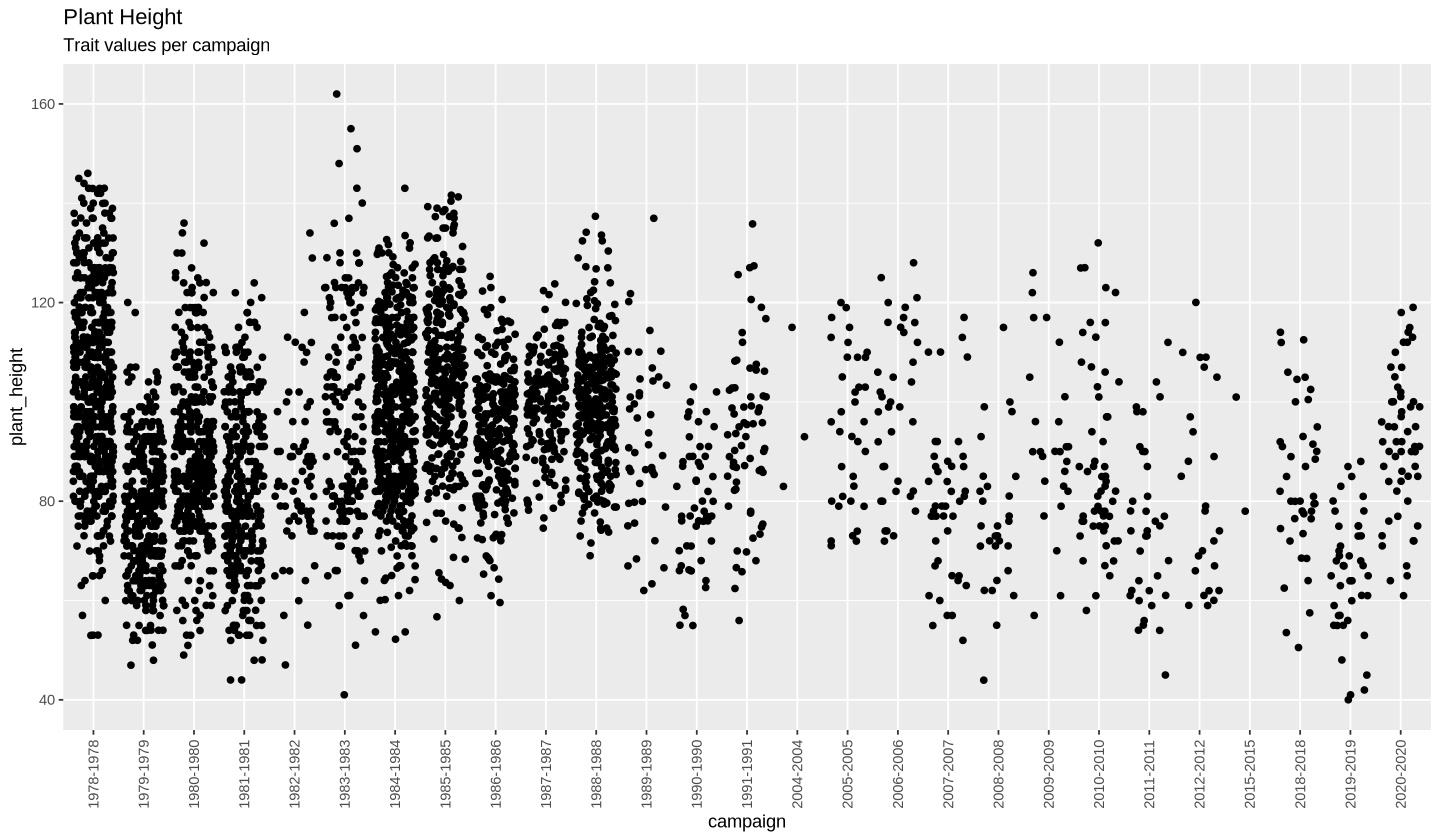

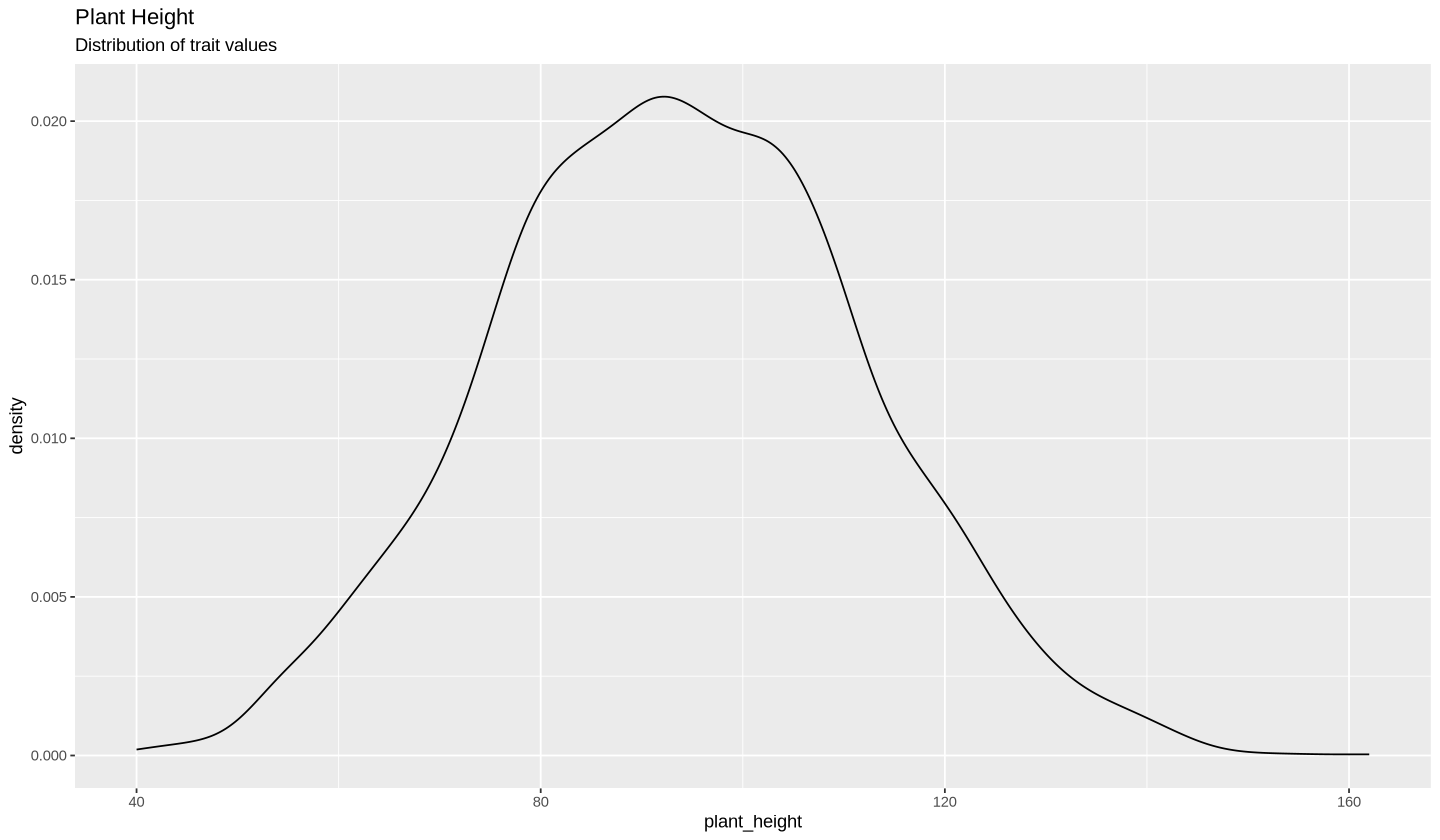

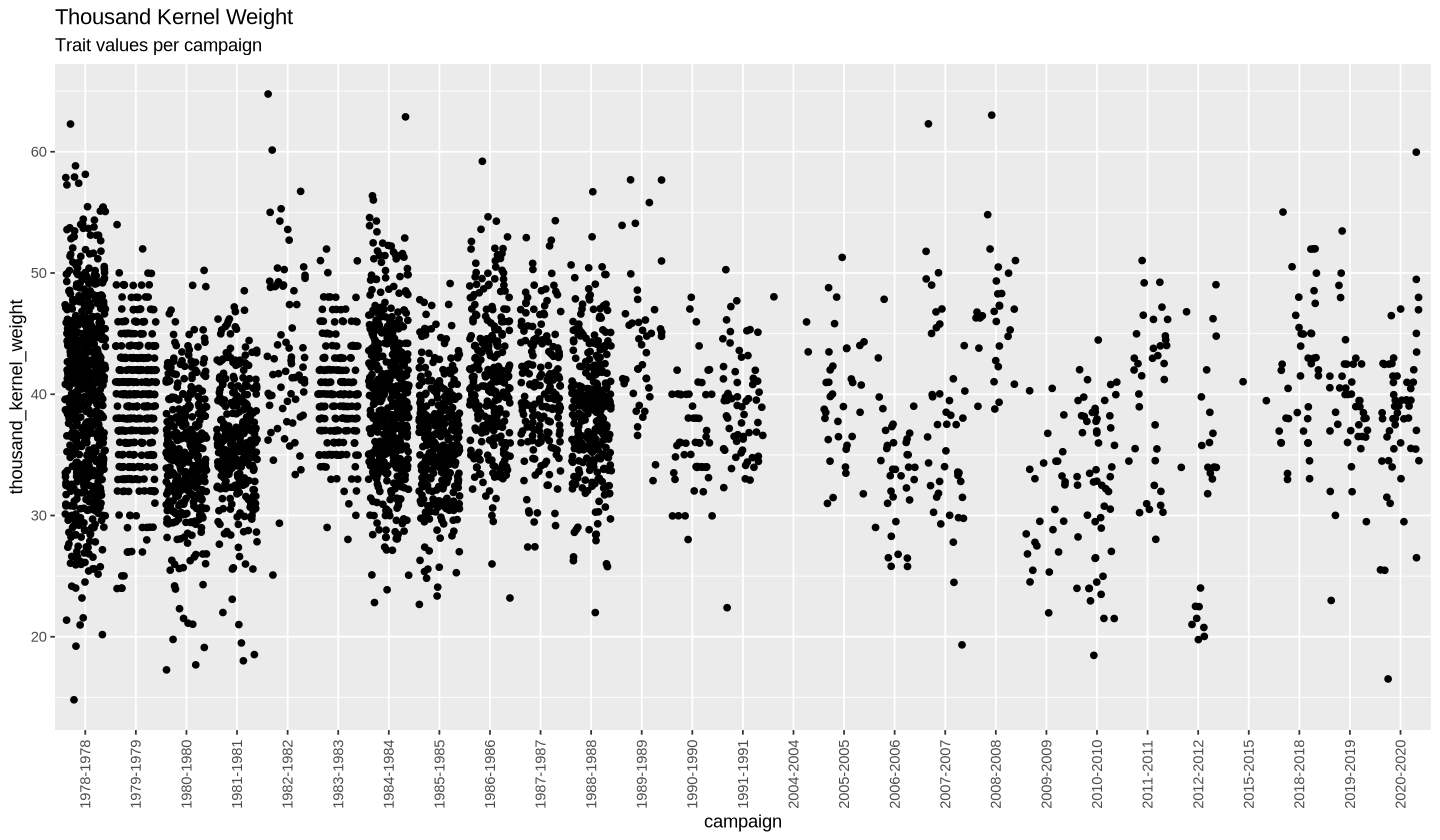

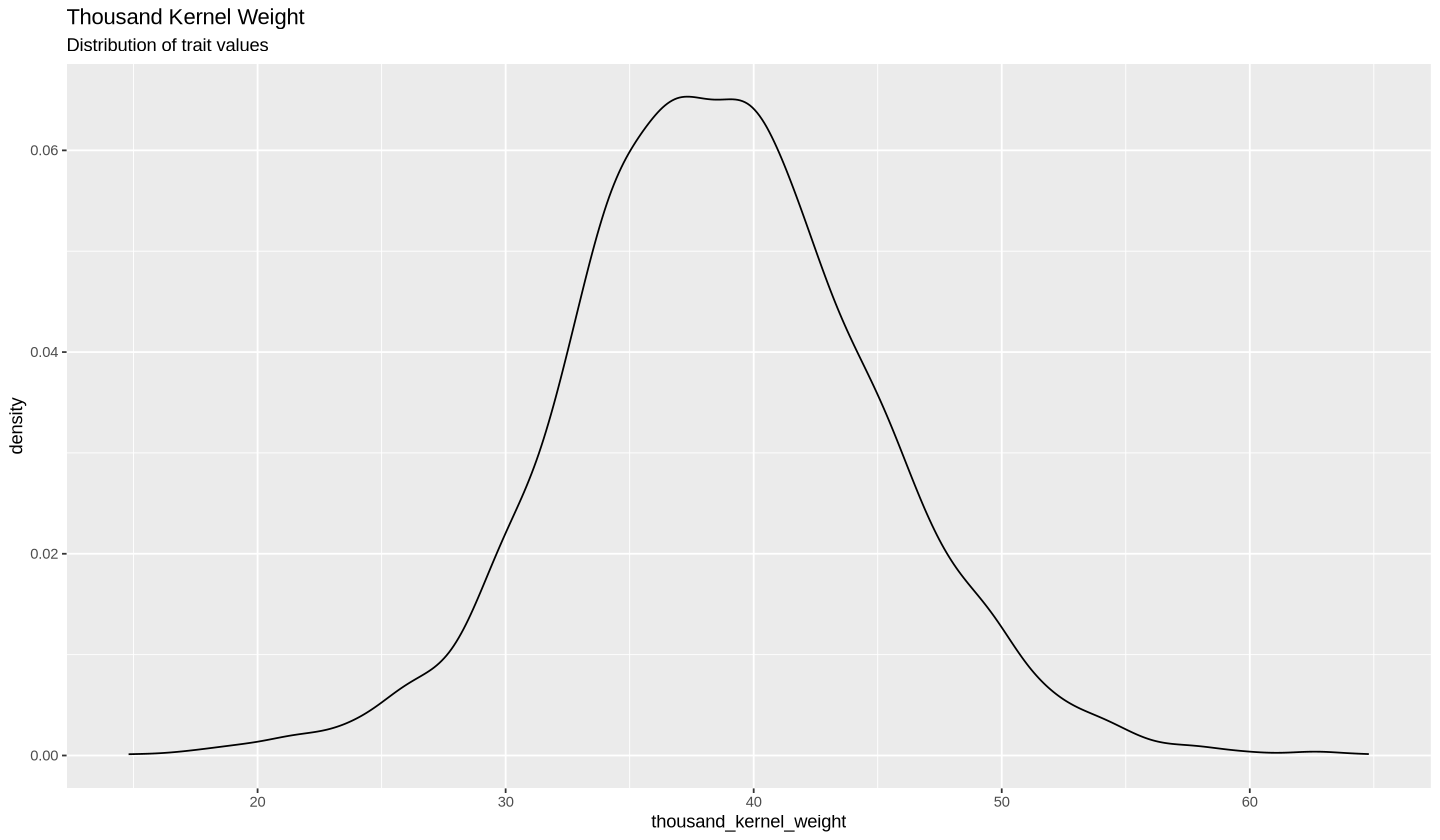

In [7]:
data_sub_SW_HT |> visualise_trait(geom_density())
data_sub_SW_PH |> visualise_trait(geom_density())
data_sub_SW_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [8]:
asreml_campaign_WW_HT <- asreml(fixed = end_of_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_WW_HT)

In [9]:
asreml_campaign_WW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_WW_PH)

In [10]:
asreml_campaign_WW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_WW_TKW)

In [11]:
asreml_campaign_SW_HT <- asreml(fixed = end_of_heading ~campaign, random = ~accenumb, 
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                              data = data_sub_SW_HT)

In [12]:
asreml_campaign_SW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_SW_PH)

In [13]:
asreml_campaign_SW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SW_TKW)

Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration”


In [14]:
campaign_effect_WW_HT <- get_campaign_effect(asreml_campaign_WW_HT)
campaign_effect_WW_PH <- get_campaign_effect(asreml_campaign_WW_PH)
campaign_effect_WW_TKW <- get_campaign_effect(asreml_campaign_WW_TKW)

In [15]:
campaign_effect_SW_HT <- get_campaign_effect(asreml_campaign_SW_HT)
campaign_effect_SW_PH <- get_campaign_effect(asreml_campaign_SW_PH)
campaign_effect_SW_TKW <- get_campaign_effect(asreml_campaign_SW_TKW)

## Extract heterogeneous error variances

In [16]:
error_var_WW_HT <- get_error_var(asreml_campaign_WW_HT)
error_var_WW_PH <- get_error_var(asreml_campaign_WW_PH)
error_var_WW_TKW <- get_error_var(asreml_campaign_WW_TKW)

In [17]:
error_var_SW_HT <- get_error_var(asreml_campaign_SW_HT)
error_var_SW_PH <- get_error_var(asreml_campaign_SW_PH)
error_var_SW_TKW <- get_error_var(asreml_campaign_SW_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [18]:
CV_df_WW_HT <- make_CV_df(campaign_effect_WW_HT, error_var_WW_HT)
CV_df_WW_PH <- make_CV_df(campaign_effect_WW_PH, error_var_WW_PH)
CV_df_WW_TKW <- make_CV_df(campaign_effect_WW_TKW, error_var_WW_TKW)

In [19]:
CV_df_SW_HT <- make_CV_df(campaign_effect_SW_HT, error_var_SW_HT)
CV_df_SW_PH <- make_CV_df(campaign_effect_SW_PH, error_var_SW_PH)
CV_df_SW_TKW <- make_CV_df(campaign_effect_SW_TKW, error_var_SW_TKW)

## Remove outlier campaigns

In [20]:
data_corrected_WW_HT_I <- data_sub_WW_HT |> correct_I(CV_df_WW_HT)
data_corrected_WW_PH_I <- data_sub_WW_PH |> correct_I(CV_df_WW_PH)
data_corrected_WW_TKW_I <- data_sub_WW_TKW |> correct_I(CV_df_WW_TKW)

0 outlier campaign(s) detected for trait end_of_heading


0 outlier campaign(s) detected for trait plant_height


1 outlier campaign(s) detected for trait thousand_kernel_weight: 1968-1969 


In [21]:
data_corrected_SW_HT_I <- data_sub_SW_HT |> correct_I(CV_df_SW_HT)
data_corrected_SW_PH_I <- data_sub_SW_PH |> correct_I(CV_df_SW_PH)
data_corrected_SW_TKW_I <- data_sub_SW_TKW |> correct_I(CV_df_SW_TKW)

0 outlier campaign(s) detected for trait end_of_heading


1 outlier campaign(s) detected for trait plant_height: 2015-2015 


0 outlier campaign(s) detected for trait thousand_kernel_weight


## Residuals

In [22]:
asreml_res_WW_HT <- asreml(fixed = end_of_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_HT_I)

In [23]:
asreml_res_WW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_PH_I)

In [24]:
asreml_res_WW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_WW_TKW_I)

Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”


Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration”


In [25]:
asreml_res_SW_HT <- asreml(fixed = end_of_heading ~ accenumb, random = ~ campaign,
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SW_HT_I)

In [26]:
asreml_res_SW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_SW_PH_I)

In [27]:
asreml_res_SW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SW_TKW_I)

213 outlier value(s) detected for trait End Of Heading 


59 outlier value(s) detected for trait Plant Height 


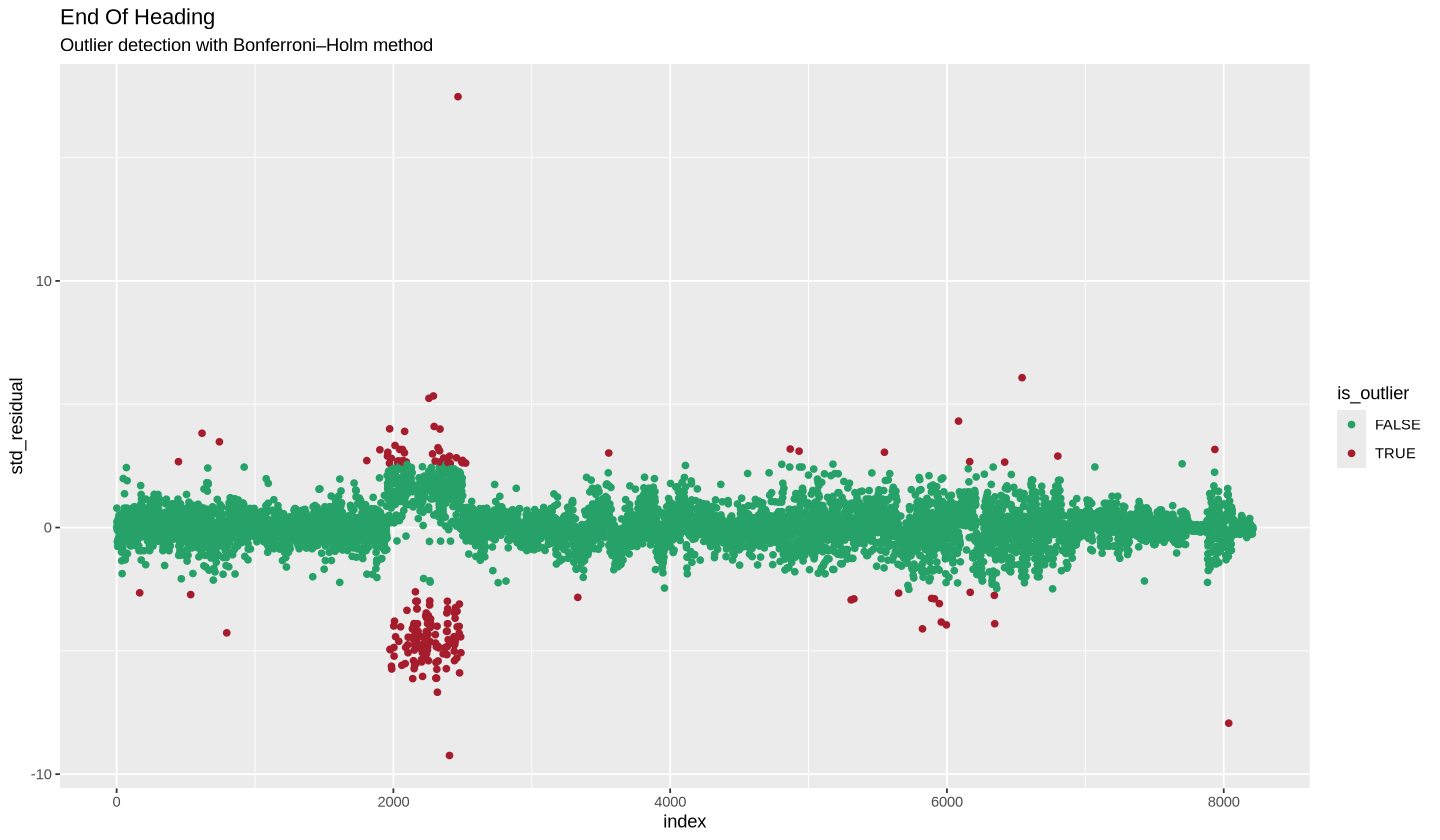

25 outlier value(s) detected for trait Thousand Kernel Weight 


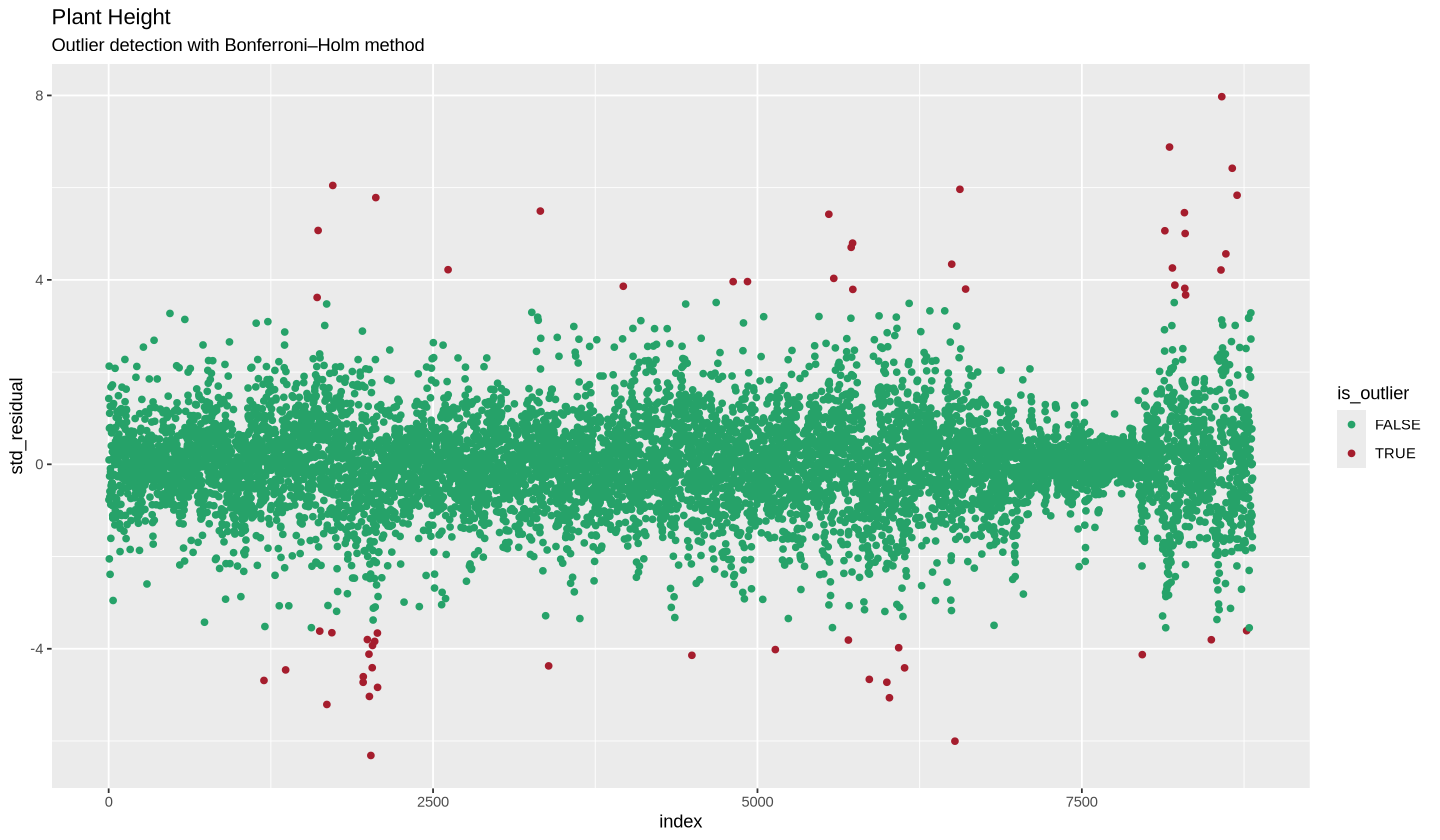

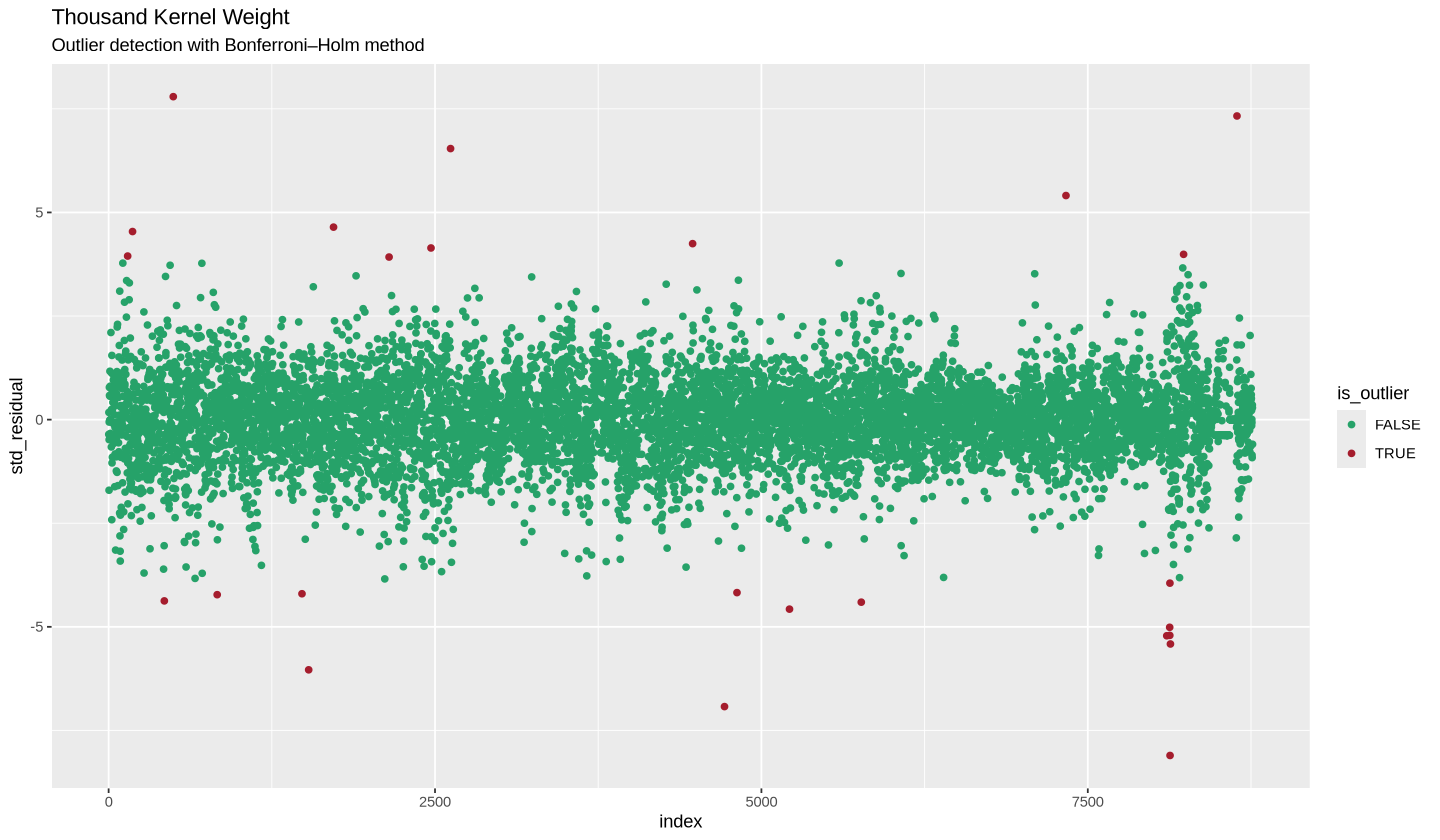

In [28]:
result_BH_WW_HT <- make_BH_multtest(asreml_res_WW_HT)
result_BH_WW_PH <- make_BH_multtest(asreml_res_WW_PH)
result_BH_WW_TKW <- make_BH_multtest(asreml_res_WW_TKW)

124 outlier value(s) detected for trait End Of Heading 


81 outlier value(s) detected for trait Plant Height 


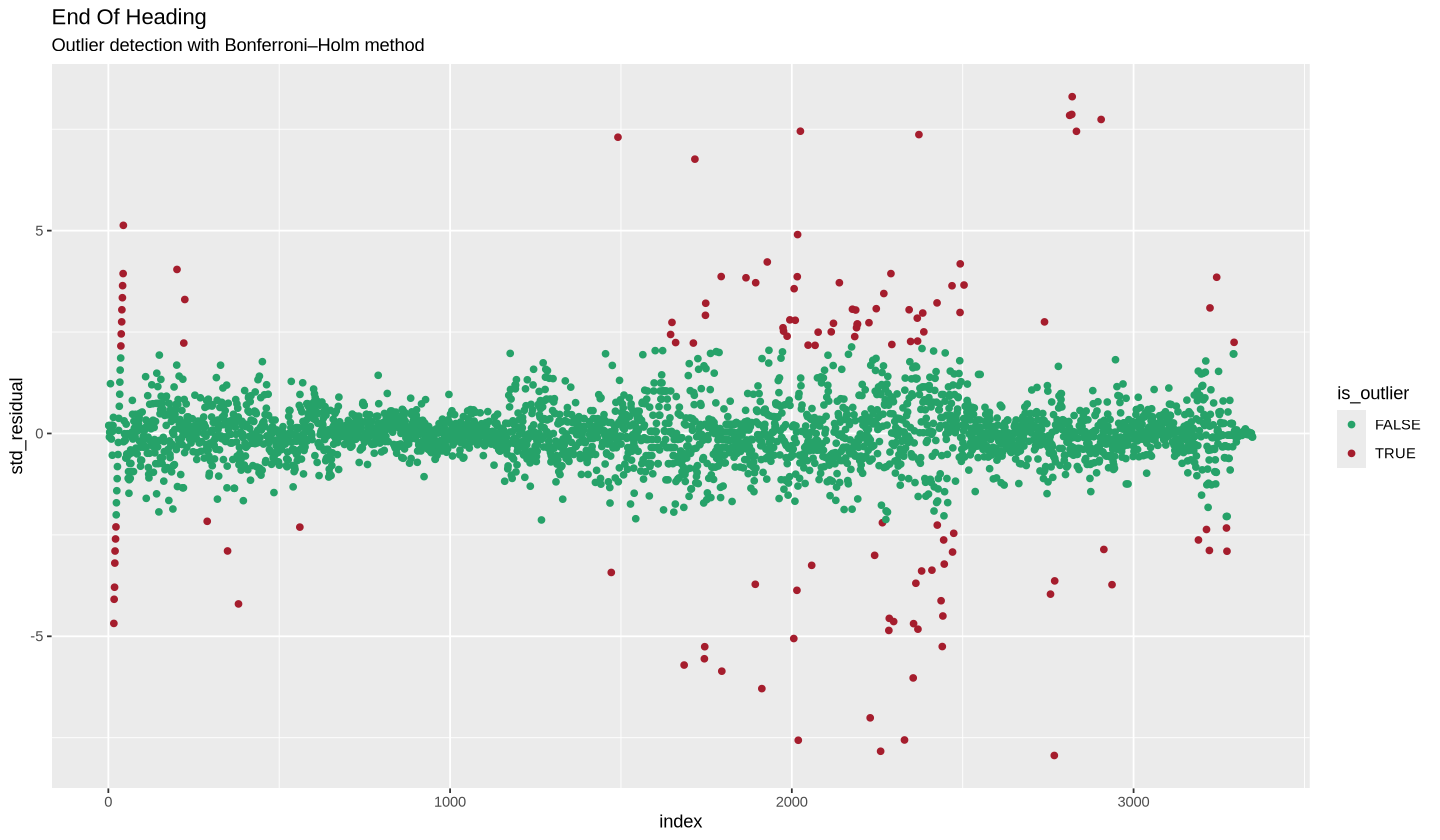

49 outlier value(s) detected for trait Thousand Kernel Weight 


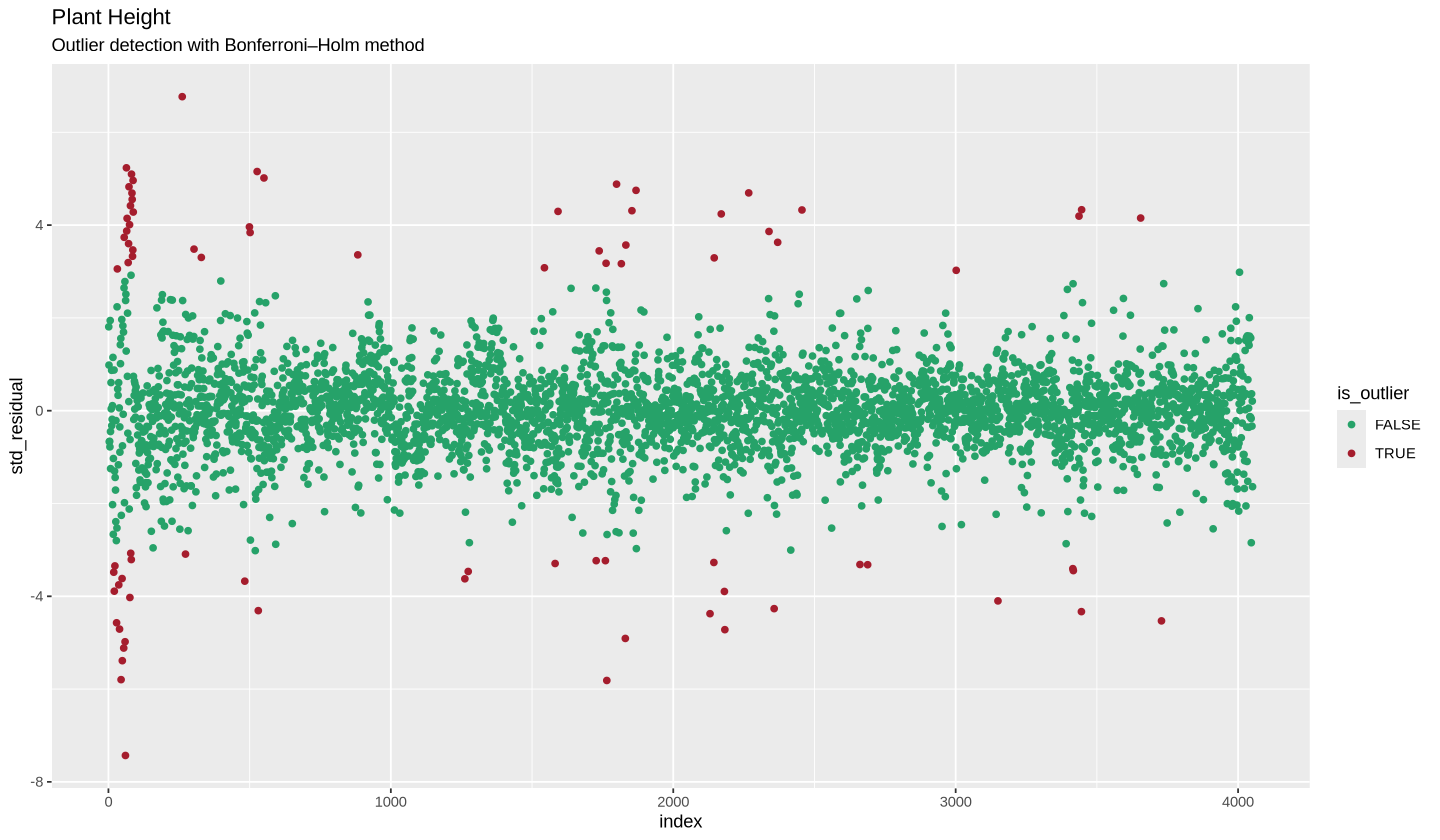

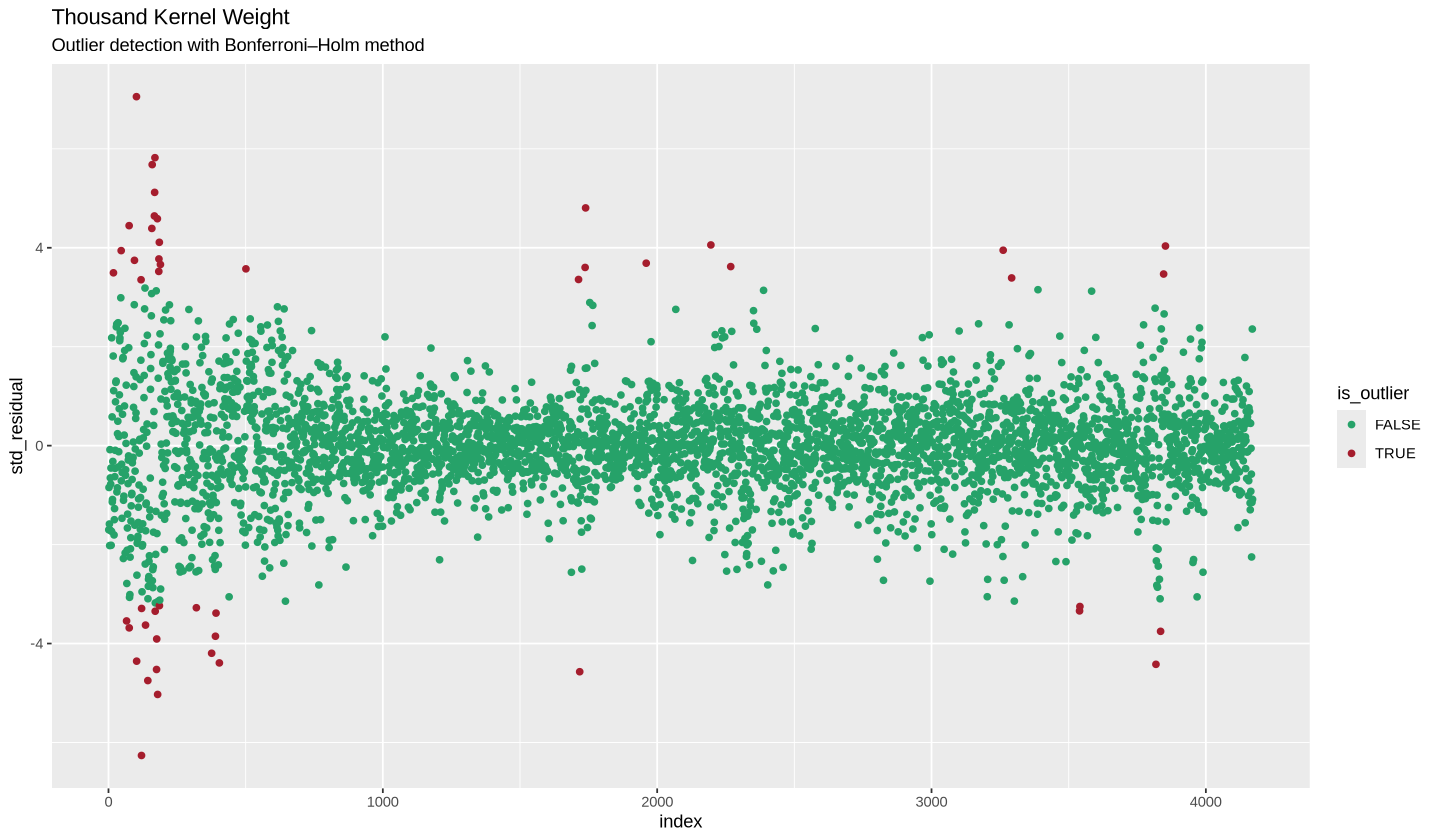

In [29]:
result_BH_SW_HT <- make_BH_multtest(asreml_res_SW_HT)
result_BH_SW_PH <- make_BH_multtest(asreml_res_SW_PH)
result_BH_SW_TKW <- make_BH_multtest(asreml_res_SW_TKW)

In [30]:
data_corrected_WW_HT_II <- data_corrected_WW_HT_I |> correct_II(result_BH_WW_HT)
data_corrected_WW_PH_II <- data_corrected_WW_PH_I |> correct_II(result_BH_WW_PH)
data_corrected_WW_TKW_II <- data_corrected_WW_TKW_I |> correct_II(result_BH_WW_TKW)

In [31]:
data_corrected_SW_HT_II <- data_corrected_SW_HT_I |> correct_II(result_BH_SW_HT)
data_corrected_SW_PH_II <- data_corrected_SW_PH_I |> correct_II(result_BH_SW_PH)
data_corrected_SW_TKW_II <- data_corrected_SW_TKW_I |> correct_II(result_BH_SW_TKW)

## Calculate heritability

In [32]:
asreml_res_h_WW_HT <- asreml(end_of_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_HT_II)

In [33]:
asreml_res_h_WW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_PH_II)

In [34]:
asreml_res_h_WW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_TKW_II)

In [35]:
asreml_res_h_SW_HT <- asreml(end_of_heading ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"), 
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_HT_II)

In [36]:
asreml_res_h_SW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_PH_II)

In [37]:
asreml_res_h_SW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                     na.action = na.method(x="omit", y="omit"),
                     residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_TKW_II)

Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Some components changed by more than 1% on the last iteration”


In [38]:
quality_WW_HT <- get_quality(data_sub_WW_HT, asreml_res_h_WW_HT)
quality_WW_PH <- get_quality(data_sub_WW_PH, asreml_res_h_WW_PH)
quality_WW_TKW <- get_quality(data_sub_WW_TKW, asreml_res_h_WW_TKW)
quality_WW_all <- bind_rows(quality_WW_HT, quality_WW_PH, quality_WW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_WW_all,"IHAR_winter_wheat_data_quality.csv")

end_of_heading heritability: 87.3 %


plant_height heritability: 93.2 %


thousand_kernel_weight heritability: 72.4 %


In [39]:
quality_SW_HT <- get_quality(data_sub_SW_HT, asreml_res_h_SW_HT)
quality_SW_PH <- get_quality(data_sub_SW_PH, asreml_res_h_SW_PH)
quality_SW_TKW <- get_quality(data_sub_SW_TKW, asreml_res_h_SW_TKW)
quality_SW_all <- bind_rows(quality_SW_HT, quality_SW_PH, quality_SW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_SW_all,"IHAR_spring_wheat_data_quality.csv")

end_of_heading heritability: 89.7 %


plant_height heritability: 92.6 %


thousand_kernel_weight heritability: 82.2 %


## Run linear mixed model with outlier corrected data

In [40]:
asreml_data_WW_HT <- asreml(end_of_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_HT_II)

In [41]:
asreml_data_WW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_PH_II)

asreml_data_WW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                           data = data_corrected_WW_TKW_II)

In [42]:
asreml_data_SW_HT <- asreml(end_of_heading ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_SW_HT_II)

In [43]:
asreml_data_SW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SW_PH_II)

In [44]:
asreml_data_SW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                           data = data_corrected_SW_TKW_II)

## Extract BLUEs and create output file

In [45]:
BLUEs_WW_HT <- get_BLUEs(asreml_data_WW_HT)
BLUEs_WW_PH <- get_BLUEs(asreml_data_WW_PH)
#BLUEs_WW_TKW <- get_BLUEs(asreml_data_WW_TKW)

BLUE_WW_all <- genotypes_w |> 
                        left_join(BLUEs_WW_HT, by="genotype") |> 
                        left_join(BLUEs_WW_PH, by="genotype") |> 
                        #left_join(BLUEs_WW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_WW_all,"IHAR_winter_wheat_BLUE_values.csv")
summary(BLUE_WW_all)

   genotype         end_of_heading_BLUE plant_height_BLUE
 Length:5267        Min.   :143.6       Min.   : 39.52   
 Class :character   1st Qu.:156.2       1st Qu.: 84.50   
 Mode  :character   Median :159.4       Median :101.99   
                    Mean   :159.7       Mean   :102.11   
                    3rd Qu.:163.3       3rd Qu.:121.31   
                    Max.   :174.3       Max.   :158.98   
                    NA's   :2055        NA's   :1860     

In [46]:
BLUEs_SW_HT <- get_BLUEs(asreml_data_SW_HT)
BLUEs_SW_PH <- get_BLUEs(asreml_data_SW_PH)
BLUEs_SW_TKW <- get_BLUEs(asreml_data_SW_TKW)


BLUE_SW_all <- genotypes_s |> 
                        left_join(BLUEs_SW_HT, by="genotype") |> 
                        left_join(BLUEs_SW_PH, by="genotype") |> 
                        left_join(BLUEs_SW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_SW_all,"IHAR_spring_wheat_BLUE_values.csv")
summary(BLUE_SW_all)

   genotype         end_of_heading_BLUE plant_height_BLUE
 Length:2340        Min.   :159.5       Min.   : 49.35   
 Class :character   1st Qu.:167.4       1st Qu.: 80.01   
 Mode  :character   Median :170.0       Median : 90.98   
                    Mean   :170.1       Mean   : 90.98   
                    3rd Qu.:172.7       3rd Qu.:101.42   
                    Max.   :190.7       Max.   :144.66   
                    NA's   :1214        NA's   :1062     
 thousand_kernel_weight_BLUE
 Min.   :21.21              
 1st Qu.:35.93              
 Median :38.62              
 Mean   :38.78              
 3rd Qu.:41.70              
 Max.   :52.56              
 NA's   :1053               

In [47]:
library(rmarkdown)
convert_ipynb("IHAR_historic_wheat_data_analysis.ipynb")

In [48]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240524.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.27      asreml_4.2.0.267    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] tid